In [116]:
import graphviz

import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
from statsmodels.api import qqplot, add_constant

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from sklearn.linear_model import Ridge, Lasso, ElasticNet

from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.decomposition import PCA
import statsmodels.api as sm
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

In [2]:
matplotlib.rc("font", family = "NanumGothic")
matplotlib.rc("axes", unicode_minus = False )

In [3]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mean_absolute_percentage_error(y_true , y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#### 데이터 전처리

In [4]:
df_raw = pd.read_csv("/home/piai/바탕화면/실습화일/2. Big Data 분석/체질검사.csv", encoding = "euc-kr")
df_raw.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,GENDER
0,35.2,46,363.15 lb,72.25 inch,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,남성
1,11.8,27,168 lb,71.25 inch,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,남성
2,22.2,69,177.75 lb,68.5 inch,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,남성
3,10.6,57,147.75 lb,65.75 inch,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,여성
4,47.5,51,219 lb,64 inch,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,여성


In [5]:
df_raw[["WEIGHT", "WEIGHT_UNIT"]] = df_raw["WEIGHT"].str.split(expand = True)
df_raw[["HEIGHT", "HEIGHT_UNIT"]] = df_raw["HEIGHT"].str.split(expand = True)
df_raw["WEIGHT"] = df_raw["WEIGHT"].astype('float64')
df_raw["HEIGHT"] = df_raw["HEIGHT"].astype('float64')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FAT          252 non-null    float64
 1   AGE          252 non-null    int64  
 2   WEIGHT       252 non-null    float64
 3   HEIGHT       252 non-null    float64
 4   NECK         252 non-null    float64
 5   CHEST        252 non-null    float64
 6   ABDOMEN      252 non-null    float64
 7   HIP          252 non-null    float64
 8   THIGH        252 non-null    float64
 9   KNEE         252 non-null    float64
 10  ANKLE        252 non-null    float64
 11  BICEPS       252 non-null    float64
 12  FOREARM      252 non-null    float64
 13  WRIST        252 non-null    float64
 14  GENDER       252 non-null    object 
 15  WEIGHT_UNIT  252 non-null    object 
 16  HEIGHT_UNIT  252 non-null    object 
dtypes: float64(13), int64(1), object(3)
memory usage: 33.6+ KB


In [6]:
df_raw = df_raw.drop(['WEIGHT_UNIT', 'HEIGHT_UNIT'], axis =1)
df_raw_dummy = pd.get_dummies(df_raw, drop_first = True)
df_raw_dummy.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,GENDER_여성
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,0
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,0
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,0
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,1
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,1


In [7]:
# fat 값이 0 이 있으면, 뒤에 분모가 0이어서 계산이 안됨
df_raw_dummy = df_raw_dummy[(df_raw_dummy['FAT'] != 0)]

In [8]:
df_raw_y = df_raw_dummy["FAT"]
df_raw_x = df_raw_dummy.drop("FAT", axis = 1 , inplace = False)

df_train, df_test = train_test_split(df_raw_dummy, test_size = 0.3 , random_state = 32)
print("train data size : {}".format(df_train.shape))
print("test data size : {}".format(df_test.shape))

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y , test_size = 0.3 , random_state = 32)

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))
df_test = df_test[(df_test['FAT'] != 0)]

train data size : (175, 15)
test data size : (76, 15)
train data X size : (175, 14)
train data Y size : (175,)
test data X size : (76, 14)
test data Y size : (76,)


#### 예측 모델 생성

In [9]:
# 회귀모델 
lr_model = smf.ols(formula = "FAT ~ HEIGHT + NECK + ABDOMEN + HIP + FOREARM", data = df_train)
lr_result = lr_model.fit()
print(lr_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     88.15
Date:                Wed, 17 May 2023   Prob (F-statistic):           3.01e-45
Time:                        15:18:33   Log-Likelihood:                -508.41
No. Observations:                 175   AIC:                             1029.
Df Residuals:                     169   BIC:                             1048.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7259      7.950      0.217      0.8

In [10]:
# Decision Tree

dt_model = DecisionTreeRegressor (random_state = 112, min_samples_leaf = 8 , 
                                 min_samples_split = 20 , max_depth = 4)
dt_model.fit(df_train_x, df_train_y)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=8, min_samples_split=20,
                      random_state=112)

In [11]:
# Random Forest
rf_model = RandomForestRegressor (random_state = 112, n_estimators = 100, 
                                min_samples_leaf = 6, min_samples_split=14 , 
                               max_depth = 4)
rf_model.fit(df_train_x, df_train_y)

RandomForestRegressor(max_depth=4, min_samples_leaf=6, min_samples_split=14,
                      random_state=112)

In [12]:
# Gradient Boosting
gb_model = GradientBoostingRegressor (random_state = 112, n_estimators = 30, 
                                min_samples_leaf = 11, min_samples_split= 22 , 
                                     max_depth = 4 , learning_rate = 0.1 )
gb_model.fit(df_train_x, df_train_y)

GradientBoostingRegressor(max_depth=4, min_samples_leaf=11,
                          min_samples_split=22, n_estimators=30,
                          random_state=112)

In [13]:
# 모델
models = ['회귀분석', '의사결정나무', '랜덤포레스트', '그래디언트 부스팅']
mse, rmse, mae , mape = [],[],[],[]

회귀 분석

In [14]:
# 예측
lr_y_pred = lr_result.predict(df_test)

# 평가
mse.append(mean_squared_error(df_test['FAT'], lr_y_pred))
rmse.append(root_mean_squared_error(df_test['FAT'], lr_y_pred))
mae.append(mean_absolute_error(df_test['FAT'], lr_y_pred))
mape.append(mean_absolute_percentage_error(df_test['FAT'], lr_y_pred))

의사결정나무

In [15]:
# 예측
dt_y_pred = dt_model.predict(df_test_x)

# 평가
mse.append(mean_squared_error(df_test_y, dt_y_pred))
rmse.append(root_mean_squared_error(df_test_y, dt_y_pred))
mae.append(mean_absolute_error(df_test_y, dt_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, dt_y_pred))

랜덤 포레스트

In [16]:
# 예측
rf_y_pred = rf_model.predict(df_test_x)

# 평가
mse.append(mean_squared_error(df_test_y, rf_y_pred))
rmse.append(root_mean_squared_error(df_test_y, rf_y_pred))
mae.append(mean_absolute_error(df_test_y, rf_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, rf_y_pred))

그래디언트 부스팅

In [17]:
# 예측
gb_y_pred = gb_model.predict(df_test_x)

# 평가
mse.append(mean_squared_error(df_test_y, gb_y_pred))
rmse.append(root_mean_squared_error(df_test_y, gb_y_pred))
mae.append(mean_absolute_error(df_test_y, gb_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, gb_y_pred))

시각화

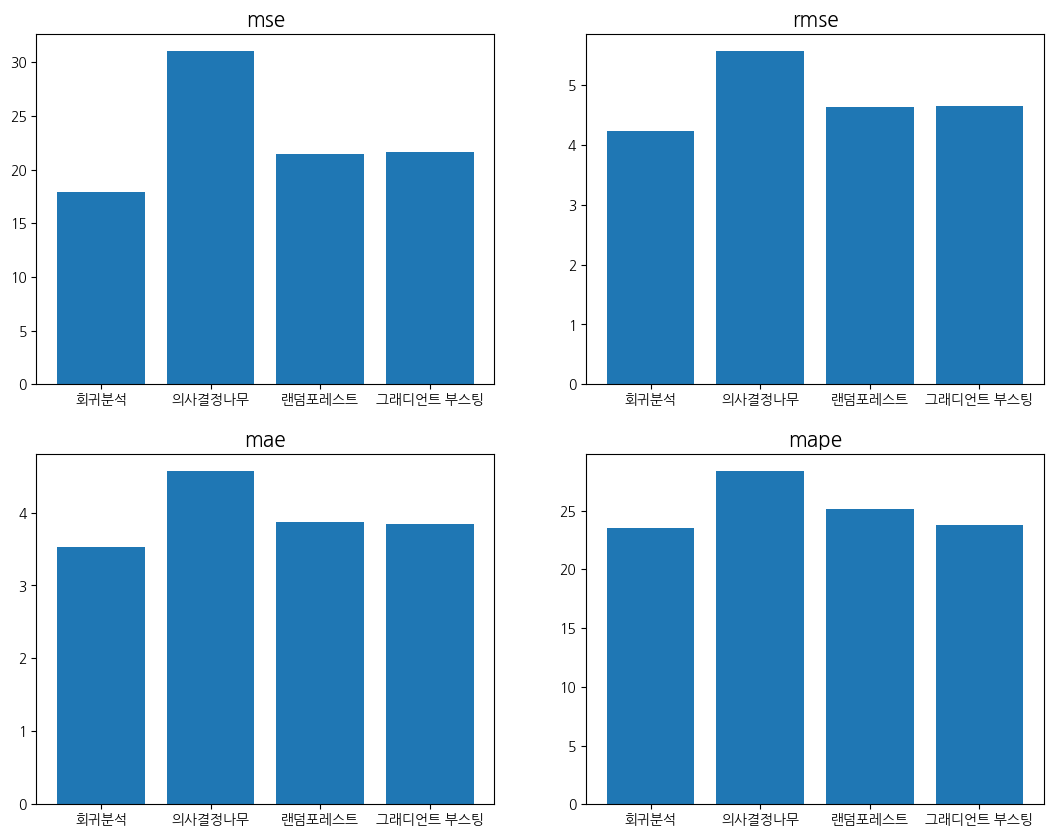

In [18]:
fig, ax = plt.subplots(2,2, figsize = (13,10))
ax[0,0].bar(models, mse)
ax[0,0].set_title("mse").set_fontsize(15)

ax[0,1].bar(models, rmse)
ax[0,1].set_title("rmse").set_fontsize(15)

ax[1,0].bar(models, mae)
ax[1,0].set_title("mae").set_fontsize(15)

ax[1,1].bar(models, mape)
ax[1,1].set_title("mape").set_fontsize(15)

In [19]:
df_test_y[(df_test_y ==0)]

Series([], Name: FAT, dtype: float64)

### 실습

##### 데이터 전처리

In [20]:
df_raw = pd.read_csv("/home/piai/바탕화면/실습화일/2. Big Data 분석/DIABETES.csv", encoding = "euc-kr")
df_raw.head()

,Y,AGE,GENDER,BMI,BP,CHOLESTEROL,LDL,HDL,TCH,LTG,GLUCOSE
0,151,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87
1,75,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69
2,141,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85
3,206,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89
4,135,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80


In [21]:
df_raw['GENDER']=df_raw['GENDER'].replace(2,0)
df_raw.head()
# 성별 남자 2=>0 으로 바꿈

,Y,AGE,GENDER,BMI,BP,CHOLESTEROL,LDL,HDL,TCH,LTG,GLUCOSE
0,151,59,0,32.1,101.0,157,93.2,38.0,4.0,4.8598,87
1,75,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69
2,141,72,0,30.5,93.0,156,93.6,41.0,4.0,4.6728,85
3,206,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89
4,135,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80


In [22]:
# 더미변수화 하기
df_raw_dummy = pd.get_dummies(df_raw, drop_first = True)
df_raw_dummy.head()

,Y,AGE,GENDER,BMI,BP,CHOLESTEROL,LDL,HDL,TCH,LTG,GLUCOSE
0,151,59,0,32.1,101.0,157,93.2,38.0,4.0,4.8598,87
1,75,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69
2,141,72,0,30.5,93.0,156,93.6,41.0,4.0,4.6728,85
3,206,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89
4,135,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80


In [23]:
df_raw_y = df_raw_dummy["Y"]
df_raw_x = df_raw_dummy.drop("Y", axis = 1 , inplace = False)

df_train, df_test = train_test_split(df_raw_dummy, test_size = 0.3 , random_state = 32)
print("train data size : {}".format(df_train.shape))
print("test data size : {}".format(df_test.shape))

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y , test_size = 0.3 , random_state = 32)

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))
df_test = df_test[(df_test['Y'] != 0)]

train data size : (309, 11)
test data size : (133, 11)
train data X size : (309, 10)
train data Y size : (309,)
test data X size : (133, 10)
test data Y size : (133,)


##### 예측 모델 생성

In [24]:
# 회귀모델 
lr_model = smf.ols(formula = "Y ~ GENDER + BMI + HDL + TCH + LTG", data = df_train)
lr_result = lr_model.fit()
print(lr_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     55.04
Date:                Wed, 17 May 2023   Prob (F-statistic):           1.43e-40
Time:                        15:18:34   Log-Likelihood:                -1686.0
No. Observations:                 309   AIC:                             3384.
Df Residuals:                     303   BIC:                             3406.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -197.4382     43.602     -4.528      0.0

In [25]:
# Decision Tree

dt_model = DecisionTreeRegressor (random_state = 112, min_samples_leaf = 8 , 
                                 min_samples_split = 20 , max_depth = 4)
dt_model.fit(df_train_x, df_train_y)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=8, min_samples_split=20,
                      random_state=112)

In [26]:
# Random Forest
rf_model = RandomForestRegressor (random_state = 112, n_estimators = 100, 
                                min_samples_leaf = 6, min_samples_split=14 , 
                               max_depth = 4)
rf_model.fit(df_train_x, df_train_y)

RandomForestRegressor(max_depth=4, min_samples_leaf=6, min_samples_split=14,
                      random_state=112)

In [27]:
# Gradient Boosting
gb_model = GradientBoostingRegressor (random_state = 112, n_estimators = 30, 
                                min_samples_leaf = 11, min_samples_split= 22 , 
                                     max_depth = 4 , learning_rate = 0.1 )
gb_model.fit(df_train_x, df_train_y)

GradientBoostingRegressor(max_depth=4, min_samples_leaf=11,
                          min_samples_split=22, n_estimators=30,
                          random_state=112)

In [28]:
# 모델
models = ['회귀분석', '의사결정나무', '랜덤포레스트', '그래디언트 부스팅']
mse, rmse, mae , mape = [],[],[],[]

회귀분석

In [29]:
# 예측
lr_y_pred = lr_result.predict(df_test)

# 평가
mse.append(mean_squared_error(df_test['Y'], lr_y_pred))
rmse.append(root_mean_squared_error(df_test['Y'], lr_y_pred))
mae.append(mean_absolute_error(df_test['Y'], lr_y_pred))
mape.append(mean_absolute_percentage_error(df_test['Y'], lr_y_pred))

의사결정나무

In [30]:
# 예측
dt_y_pred = dt_model.predict(df_test_x)

# 평가
mse.append(mean_squared_error(df_test_y, dt_y_pred))
rmse.append(root_mean_squared_error(df_test_y, dt_y_pred))
mae.append(mean_absolute_error(df_test_y, dt_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, dt_y_pred))

랜덤 포레스트

In [31]:
# 예측
rf_y_pred = rf_model.predict(df_test_x)

# 평가
mse.append(mean_squared_error(df_test_y, rf_y_pred))
rmse.append(root_mean_squared_error(df_test_y, rf_y_pred))
mae.append(mean_absolute_error(df_test_y, rf_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, rf_y_pred))

그래디언트 부스팅

In [32]:
# 예측
gb_y_pred = gb_model.predict(df_test_x)

# 평가
mse.append(mean_squared_error(df_test_y, gb_y_pred))
rmse.append(root_mean_squared_error(df_test_y, gb_y_pred))
mae.append(mean_absolute_error(df_test_y, gb_y_pred))
mape.append(mean_absolute_percentage_error(df_test_y, gb_y_pred))

시각화

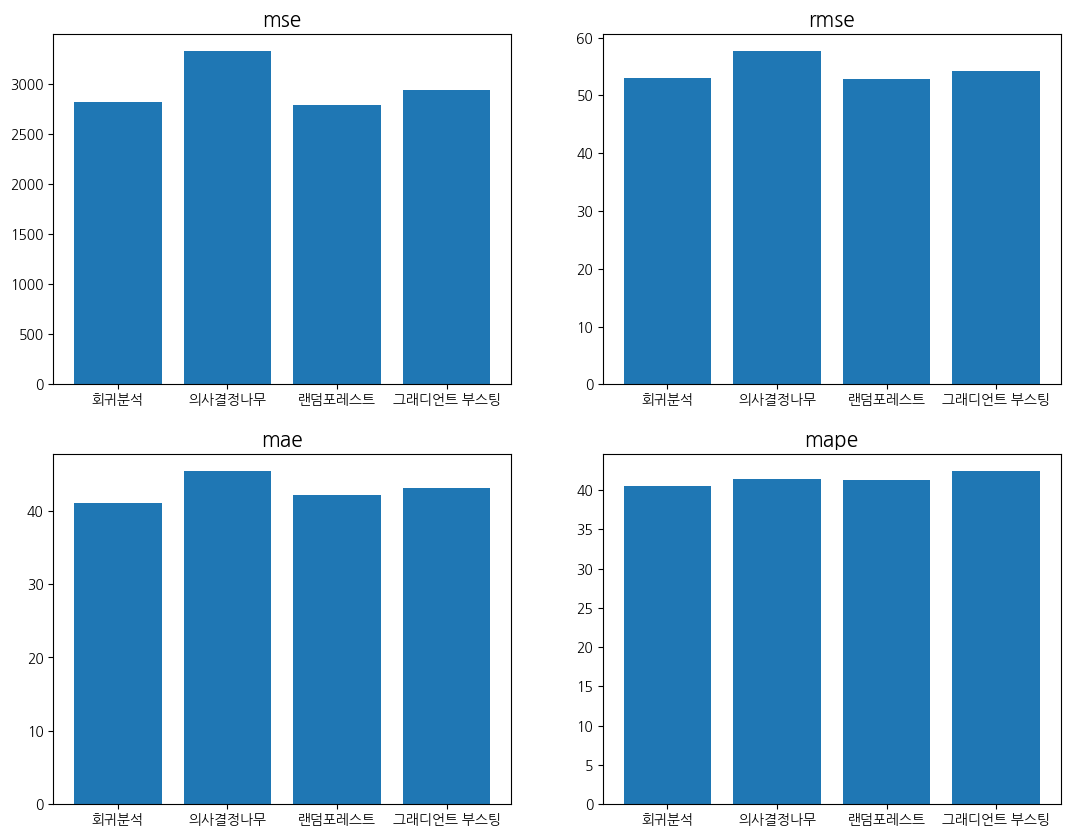

In [33]:
fig, ax = plt.subplots(2,2, figsize = (13,10))
ax[0,0].bar(models, mse)
ax[0,0].set_title("mse").set_fontsize(15)

ax[0,1].bar(models, rmse)
ax[0,1].set_title("rmse").set_fontsize(15)

ax[1,0].bar(models, mae)
ax[1,0].set_title("mae").set_fontsize(15)

ax[1,1].bar(models, mape)
ax[1,1].set_title("mape").set_fontsize(15)

In [34]:
df_test_y[(df_test_y ==0)]

Series([], Name: Y, dtype: int64)

# 주성분 분석

In [35]:
# 데이터 불러오기
df_raw = pd.read_csv('/home/piai/바탕화면/실습화일/2. Big Data 분석/직무능력평가.csv' , encoding = 'euc-kr')
df_raw.head()

,EVAL,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION
0,43,51,30,39,61,92,45
1,63,64,51,54,63,73,47
2,71,70,68,69,76,86,48
3,61,63,45,47,54,84,35
4,81,78,56,66,71,83,47


In [36]:
# 데이터 불러오기
df_raw_x = df_raw.drop('EVAL', axis = 1)
df_raw_y = df_raw['EVAL']

df_raw_y.head()


0    43
1    63
2    71
3    61
4    81
Name: EVAL, dtype: int64

In [37]:
df_raw_x.head()

,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION
0,51,30,39,61,92,45
1,64,51,54,63,73,47
2,70,68,69,76,86,48
3,63,45,47,54,84,35
4,78,56,66,71,83,47


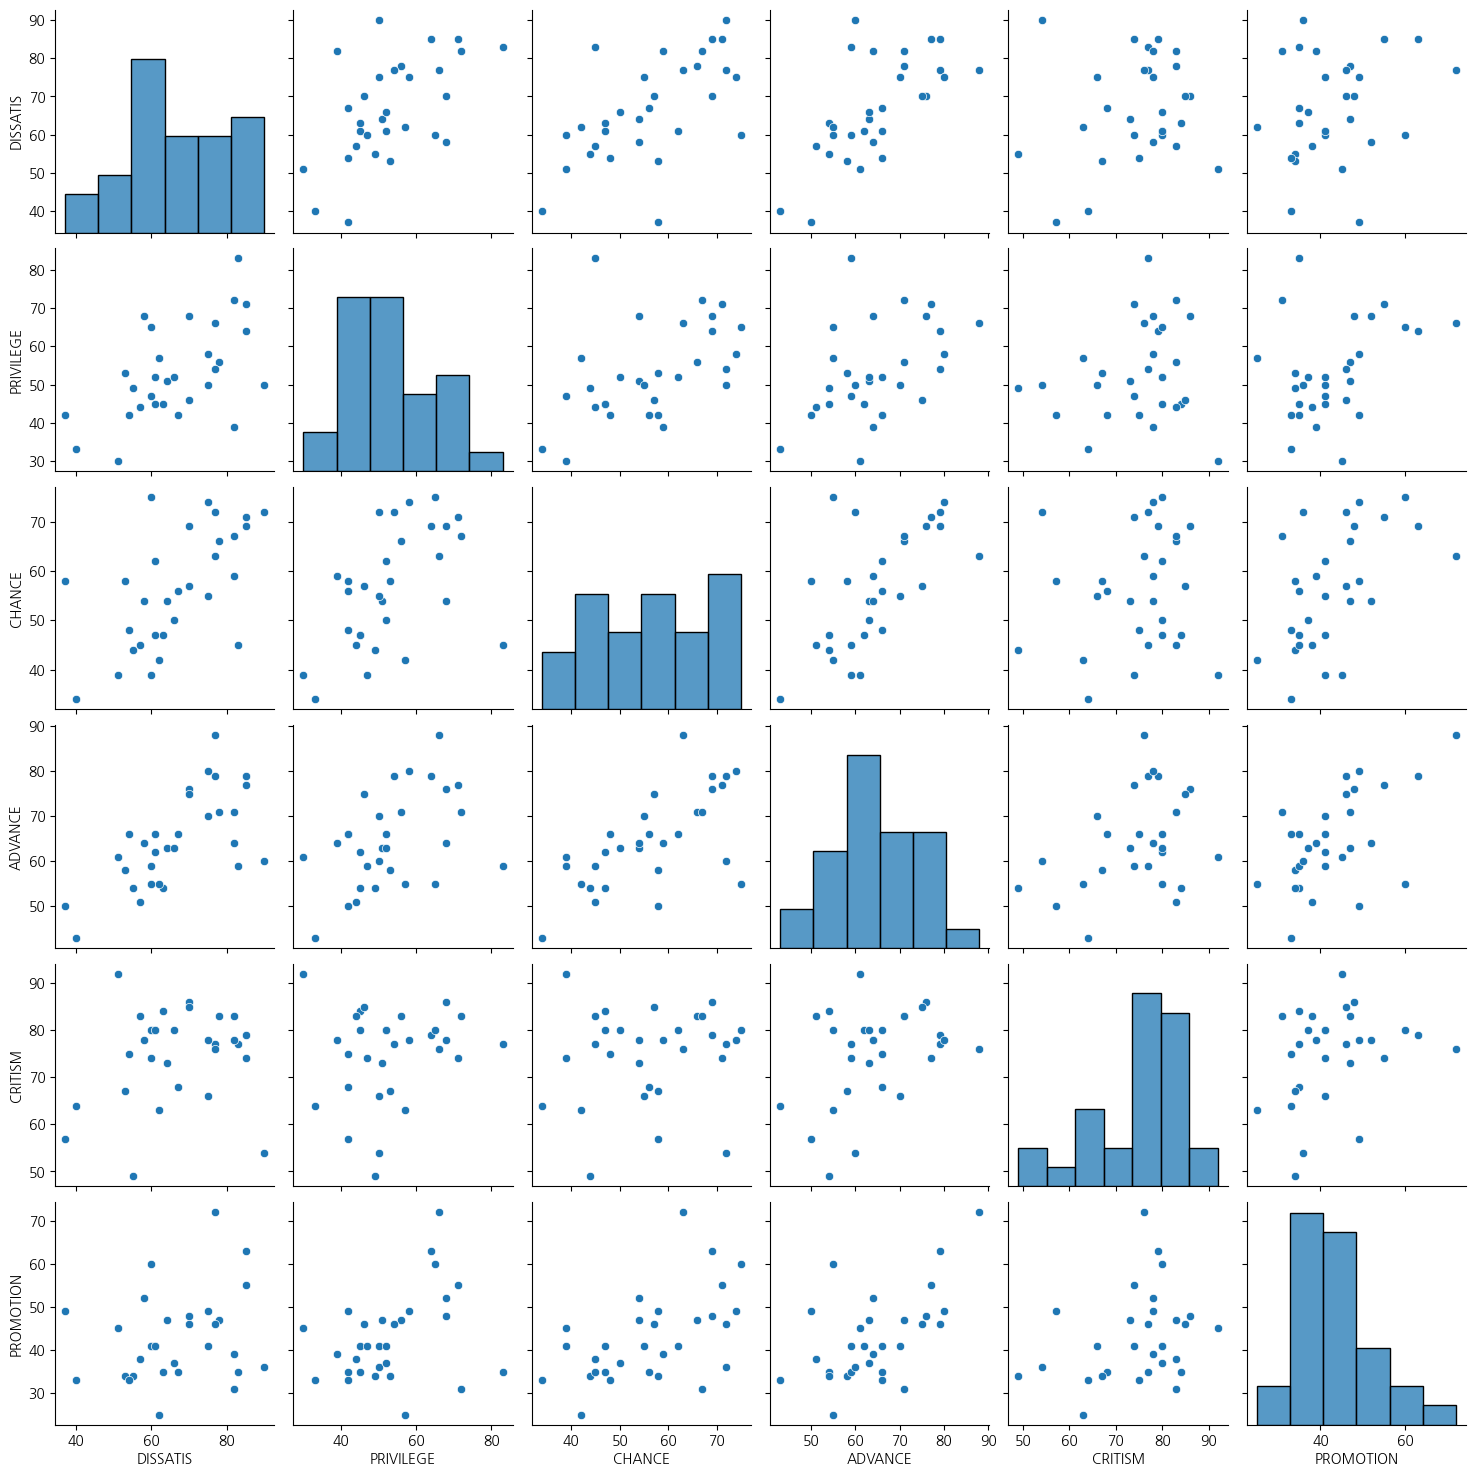

In [38]:
sns.pairplot(df_raw_x)

##### 데이터 확인 및 scaling

In [39]:
df_raw_x.corr().round(3)

,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION
DISSATIS,1.000,0.558,0.597,0.669,0.188,0.225
PRIVILEGE,0.558,1.000,0.493,0.445,0.147,0.343
CHANCE,0.597,0.493,1.000,0.640,0.116,0.532
ADVANCE,0.669,0.445,0.640,1.000,0.377,0.574
CRITISM,0.188,0.147,0.116,0.377,1.000,0.283
PROMOTION,0.225,0.343,0.532,0.574,0.283,1.000


In [40]:
df_raw_x.describe().round(3)

,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION
count,30.000,30.000,30.000,30.000,30.000,30.000
mean,66.600,53.133,56.367,64.633,74.767,42.933
std,13.315,12.235,11.737,10.397,9.895,10.289
min,37.000,30.000,34.000,43.000,49.000,25.000
25%,58.500,45.000,47.000,58.250,69.250,35.000
50%,65.000,51.500,56.500,63.500,77.500,41.000
75%,77.000,62.500,66.750,71.000,80.000,47.750
max,90.000,83.000,75.000,88.000,92.000,72.000


In [41]:
x_cols = df_raw_x.columns
scaler = StandardScaler()
nd_scaled = scaler.fit_transform(df_raw_x)

print("Scaled Data :\n {}".format(nd_scaled[:5].round(3)))
print("Shape : \n{}".format(nd_scaled))

Scaled Data :
 [[-1.192 -1.923 -1.505 -0.355  1.771  0.204]
 [-0.199 -0.177 -0.205 -0.16  -0.182  0.402]
 [ 0.26   1.236  1.095  1.112  1.155  0.501]
 [-0.275 -0.676 -0.812 -1.04   0.949 -0.784]
 [ 0.871  0.238  0.835  0.623  0.846  0.402]]
Shape : 
[[-1.19166169 -1.92300586 -1.50494461 -0.35542617  1.77141034  0.20430138]
 [-0.19861028 -0.17733772 -0.20508842 -0.15977874 -0.18159526  0.4020124 ]
 [ 0.25972114  1.23582221  1.09476777  1.11192959  1.15467173  0.50086791]
 [-0.27499885 -0.67610004 -0.81168798 -1.0401922   0.9490922  -0.78425369]
 [ 0.87082969  0.23829756  0.83479653  0.622811    0.84630243  0.4020124 ]
 [-0.88610741 -0.34359183 -1.07165921 -1.0401922  -2.6485497  -0.8831092 ]
 [ 0.03055543 -0.92548121 -0.03177426  0.13369241 -0.6955441  -0.78425369]
 [ 0.64166398 -0.26046477 -0.11843134  0.52498728 -0.90112364 -0.19112065]
 [ 1.17638397  1.56833043  0.92145361  0.622811    0.84630243 -1.17967572]
 [-0.42777599 -0.67610004 -0.81168798 -0.25760246  0.53793312 -0.19112065]


In [42]:
df_scaled = pd.DataFrame(nd_scaled, columns = x_cols)
df_scaled.head().round(3)

,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION
0,-1.192,-1.923,-1.505,-0.355,1.771,0.204
1,-0.199,-0.177,-0.205,-0.160,-0.182,0.402
2,0.260,1.236,1.095,1.112,1.155,0.501
3,-0.275,-0.676,-0.812,-1.040,0.949,-0.784
4,0.871,0.238,0.835,0.623,0.846,0.402


In [43]:
df_scaled.describe().round(3)

,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION
count,30.000,30.000,30.000,30.000,30.000,30.000
mean,0.000,0.000,-0.000,-0.000,0.000,0.000
std,1.017,1.017,1.017,1.017,1.017,1.017
min,-2.261,-1.923,-1.938,-2.116,-2.649,-1.773
25%,-0.619,-0.676,-0.812,-0.624,-0.567,-0.784
50%,-0.122,-0.136,0.012,-0.111,0.281,-0.191
75%,0.794,0.779,0.900,0.623,0.538,0.476
max,1.787,2.483,1.615,2.286,1.771,2.873


###### 주성분 분석

In [59]:
pca = PCA(n_components = 6)
nd_pca = pca.fit_transform(df_scaled)

print("PCA Data : \n{}".format(nd_pca[:5]))
print("Shape : \n {}". format(nd_pca.shape))

PCA Data : 
[[ 1.67606983 -2.73856419 -0.12843595 -0.50321261  0.24330658  0.22576117]
 [ 0.21834397 -0.12615302  0.43115839  0.08726221  0.19566103  0.1941439 ]
 [-2.10515127 -0.51500683 -0.27683087  0.49131136 -0.44691698 -0.63174369]
 [ 1.35994032 -0.86064574 -0.91799066  0.03173793 -0.40137177  0.44095403]
 [-1.5120347  -0.35277019 -0.32684445 -0.32877858 -0.32709718  0.21246099]]
Shape : 
 (30, 6)


In [60]:
df_pca = pd.DataFrame(nd_pca, columns = ["Prin1" , "Prin2" , "Prin3", "Prin4", "Prin5" , 'Prin6'])
df_scaled_pca = df_scaled.join(df_pca)
df_scaled.head()

,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION
0,-1.191662,-1.923006,-1.504945,-0.355426,1.771410,0.204301
1,-0.198610,-0.177338,-0.205088,-0.159779,-0.181595,0.402012
2,0.259721,1.235822,1.094768,1.111930,1.154672,0.500868
3,-0.274999,-0.676100,-0.811688,-1.040192,0.949092,-0.784254
4,0.870830,0.238298,0.834797,0.622811,0.846302,0.402012


In [61]:
df_scaled_pca = df_scaled.join(df_pca)
df_scaled_pca.head()

,DISSATIS,PRIVILEGE,CHANCE,ADVANCE,CRITISM,PROMOTION,Prin1,Prin2,Prin3,Prin4,Prin5,Prin6
0,-1.191662,-1.923006,-1.504945,-0.355426,1.771410,0.204301,1.676070,-2.738564,-0.128436,-0.503213,0.243307,0.225761
1,-0.198610,-0.177338,-0.205088,-0.159779,-0.181595,0.402012,0.218344,-0.126153,0.431158,0.087262,0.195661,0.194144
2,0.259721,1.235822,1.094768,1.111930,1.154672,0.500868,-2.105151,-0.515007,-0.276831,0.491311,-0.446917,-0.631744
3,-0.274999,-0.676100,-0.811688,-1.040192,0.949092,-0.784254,1.359940,-0.860646,-0.917991,0.031738,-0.401372,0.440954
4,0.870830,0.238298,0.834797,0.622811,0.846302,0.402012,-1.512035,-0.352770,-0.326844,-0.328779,-0.327097,0.212461


In [62]:
df_pca_stat = pd.DataFrame()
df_pca_stat['PrinNo'] = [l for l in range(1,7)]
df_pca_stat['EigenValues'] = pca.explained_variance_
df_pca_stat['EigenValuesRatio'] = pca.explained_variance_ratio_
df_pca_stat['CumEigenValuesRatio'] = np.cumsum(pca.explained_variance_ratio_)
df_pca_stat.round(3)

,PrinNo,EigenValues,EigenValuesRatio,CumEigenValuesRatio
0,1,3.279,0.528,0.528
1,2,1.041,0.168,0.696
2,3,0.789,0.127,0.823
3,4,0.572,0.092,0.915
4,5,0.328,0.053,0.968
5,6,0.198,0.032,1.000


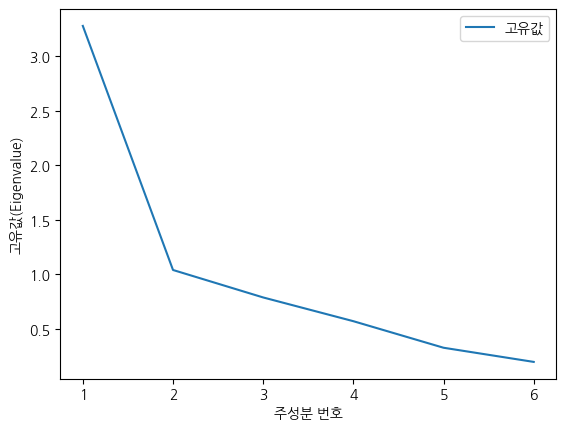

In [63]:
# Scree Plot
plt.plot(df_pca_stat['PrinNo'], df_pca_stat['EigenValues'], label = '고유값')
plt.ylabel('고유값(Eigenvalue)')
plt.xlabel('주성분 번호')
plt.legend(loc = 'best')

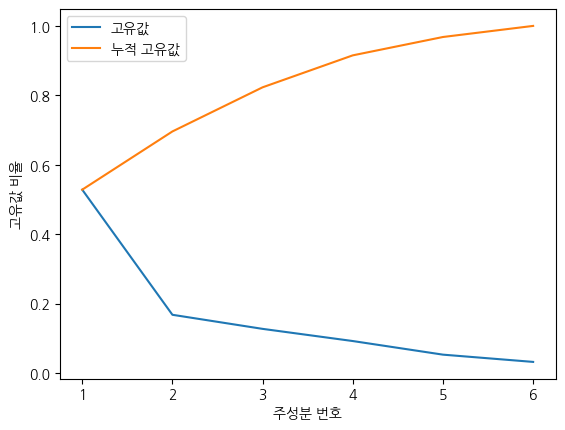

In [64]:
# 고유값 비율 그래프 생성
plt.plot(df_pca_stat['PrinNo'], df_pca_stat['EigenValuesRatio'], label = '고유값')
plt.plot(df_pca_stat['PrinNo'], df_pca_stat['CumEigenValuesRatio'], label = '누적 고유값')
plt.ylabel('고유값 비율')
plt.xlabel('주성분 번호')
plt.legend(loc = 'best')

In [65]:
x_cols = pd.DataFrame({"Feature":df_raw_x.columns})

df_eigenvector = pd.concat([x_cols, pd.DataFrame(pca.components_.T * -1 , \
                                                columns = ["Prin1","Prin2","Prin3","Prin4","Prin5","Prin6"])], axis = 1)
df_eigenvector.round(3)

,Feature,Prin1,Prin2,Prin3,Prin4,Prin5,Prin6
0,DISSATIS,0.439,-0.313,0.445,0.316,-0.192,-0.612
1,PRIVILEGE,0.395,-0.309,0.217,-0.815,-0.038,0.190
2,CHANCE,0.461,-0.217,-0.272,0.225,0.776,0.118
3,ADVANCE,0.493,0.116,0.006,0.365,-0.460,0.631
4,CRITISM,0.225,0.802,0.457,-0.100,0.289,-0.058
5,PROMOTION,0.381,0.321,-0.687,-0.206,-0.255,-0.416


,Prin1,Prin2,Prin3,Prin4,Prin5,Prin6
Prin1,1.0,0.0,-0.0,-0.0,0.0,0.0
Prin2,0.0,1.0,0.0,-0.0,0.0,0.0
Prin3,-0.0,0.0,1.0,0.0,-0.0,-0.0
Prin4,-0.0,-0.0,0.0,1.0,0.0,-0.0
Prin5,0.0,0.0,-0.0,0.0,1.0,0.0
Prin6,0.0,0.0,-0.0,-0.0,0.0,1.0


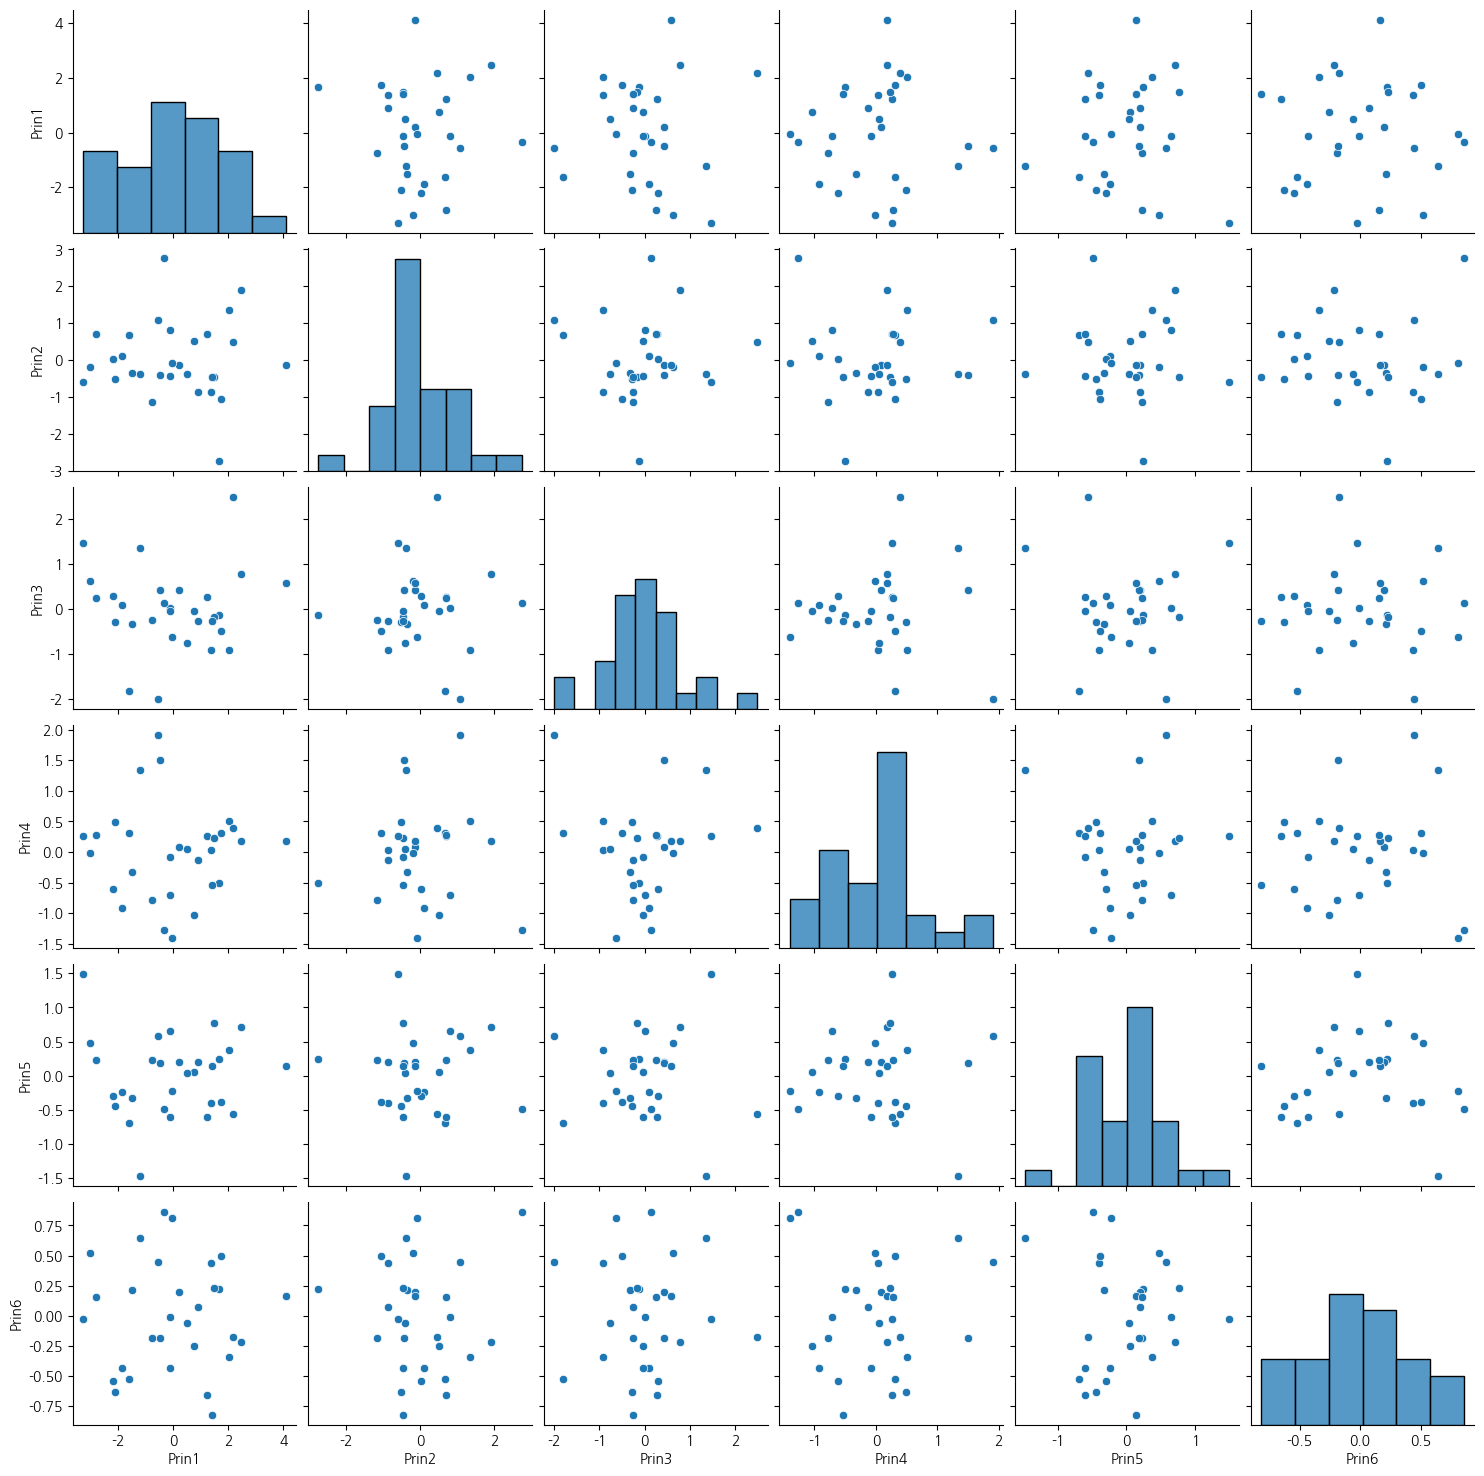

In [66]:
sns.pairplot(df_pca)
df_pca.corr().round(3)

In [67]:
df_raw_x_const = sm.add_constant(df_raw_x)
reg_model = sm.OLS(df_raw_y, df_raw_x_const)
reg_model = reg_model.fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   EVAL   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     10.50
Date:                Wed, 17 May 2023   Prob (F-statistic):           1.24e-05
Time:                        15:21:42   Log-Likelihood:                -97.250
No. Observations:                  30   AIC:                             208.5
Df Residuals:                      23   BIC:                             218.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.7871     11.589      0.931      0.3

In [68]:
df_scaled_const = sm.add_constant(df_scaled)
reg_model = sm.OLS(df_raw_y, df_scaled_const)
reg_model = reg_model.fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   EVAL   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     10.50
Date:                Wed, 17 May 2023   Prob (F-statistic):           1.24e-05
Time:                        15:21:44   Log-Likelihood:                -97.250
No. Observations:                  30   AIC:                             208.5
Df Residuals:                      23   BIC:                             218.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.6333      1.290     50.087      0.0

In [69]:
df_pca

,Prin1,Prin2,Prin3,Prin4,Prin5,Prin6
0,1.676070,-2.738564,-0.128436,-0.503213,0.243307,0.225761
1,0.218344,-0.126153,0.431158,0.087262,0.195661,0.194144
2,-2.105151,-0.515007,-0.276831,0.491311,-0.446917,-0.631744
3,1.359940,-0.860646,-0.917991,0.031738,-0.401372,0.440954
4,-1.512035,-0.352770,-0.326844,-0.328779,-0.327097,0.212461
5,2.463594,1.912424,0.788183,0.174332,0.709853,-0.214980
6,0.755680,0.510980,-0.042249,-1.036323,0.058321,-0.252712
7,-0.107754,0.818047,0.016631,-0.709458,0.658251,-0.007035
8,-1.608941,0.679477,-1.814521,0.313533,-0.688569,-0.522567
9,0.908086,-0.859195,-0.259094,-0.124773,0.199506,0.076567


In [70]:
x_var = ['Prin1', 'Prin2', 'Prin3']
df_pca_const = sm.add_constant(df_pca[x_var])

reg_model = sm.OLS(df_raw_y, df_pca_const)
reg_model = reg_model.fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   EVAL   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     14.36
Date:                Wed, 17 May 2023   Prob (F-statistic):           1.02e-05
Time:                        15:21:57   Log-Likelihood:                -102.38
No. Observations:                  30   AIC:                             212.8
Df Residuals:                      26   BIC:                             218.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.6333      1.440     44.890      0.0

## 주성분 분석 실습

In [71]:
# 데이터 불러오기
df_raw = pd.read_csv('/home/piai/바탕화면/실습화일/2. Big Data 분석/IRIS.csv' , encoding = 'euc-kr')
df_raw.head()

,SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH,SPECIES
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [72]:
# 
df_raw_x = df_raw.drop('SPECIES', axis = 1)
df_raw_y = df_raw['SPECIES']

df_raw_y.head()

0    setosa
1    setosa
2    setosa
3    setosa
4    setosa
Name: SPECIES, dtype: object

In [73]:
df_raw_x.head()

,SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


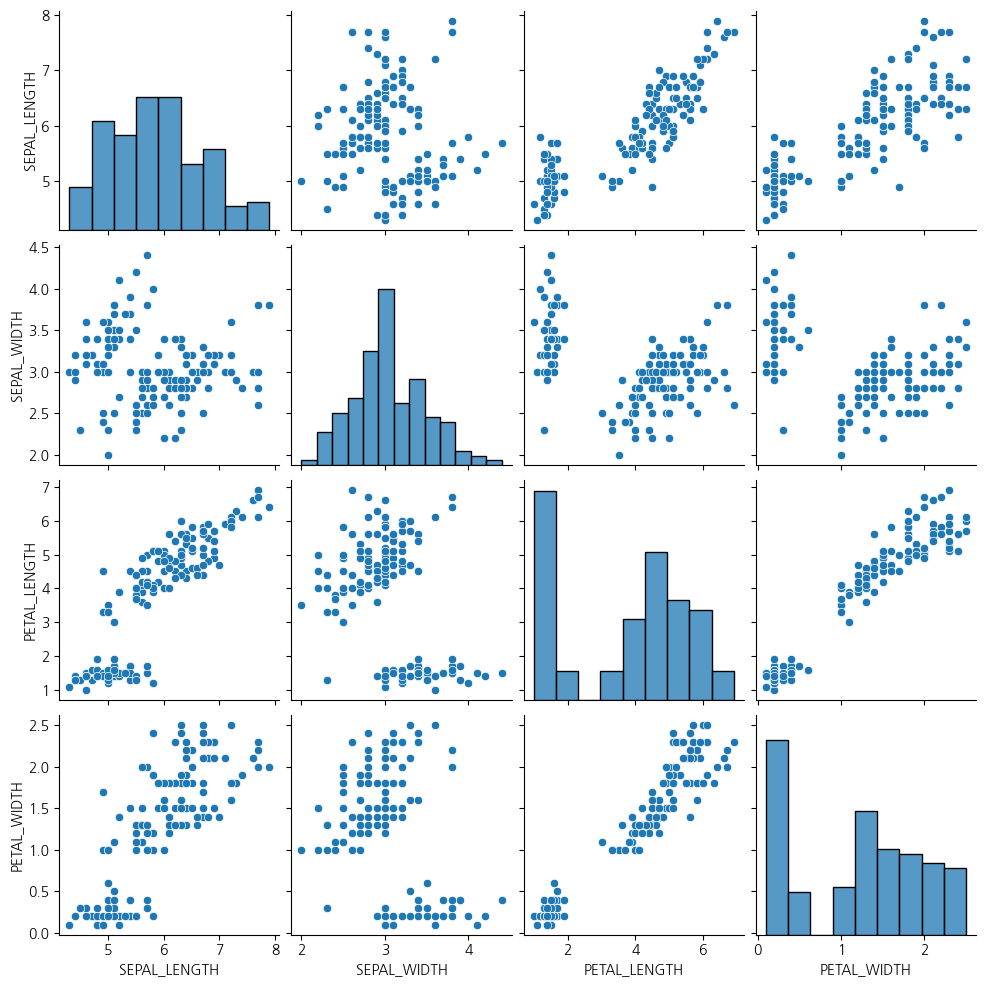

In [74]:
sns.pairplot(df_raw_x)

In [75]:
df_raw_x.corr().round(3)

,SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH
SEPAL_LENGTH,1.000,-0.118,0.872,0.818
SEPAL_WIDTH,-0.118,1.000,-0.428,-0.366
PETAL_LENGTH,0.872,-0.428,1.000,0.963
PETAL_WIDTH,0.818,-0.366,0.963,1.000


In [76]:
df_raw_x.describe().round(3)

,SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH
count,150.000,150.000,150.000,150.000
mean,5.843,3.057,3.758,1.199
std,0.828,0.436,1.765,0.762
min,4.300,2.000,1.000,0.100
25%,5.100,2.800,1.600,0.300
50%,5.800,3.000,4.350,1.300
75%,6.400,3.300,5.100,1.800
max,7.900,4.400,6.900,2.500


In [77]:
x_cols = df_raw_x.columns
scaler = StandardScaler()
nd_scaled = scaler.fit_transform(df_raw_x)

print("Scaled Data :\n {}".format(nd_scaled[:5].round(3)))
print("Shape : \n{}".format(nd_scaled))

Scaled Data :
 [[-0.901  1.019 -1.34  -1.315]
 [-1.143 -0.132 -1.34  -1.315]
 [-1.385  0.328 -1.397 -1.315]
 [-1.507  0.098 -1.283 -1.315]
 [-1.022  1.249 -1.34  -1.315]]
Shape : 
[[-9.00681170e-01  1.01900435e+00 -1.34022653e+00 -1.31544430e+00]
 [-1.14301691e+00 -1.31979479e-01 -1.34022653e+00 -1.31544430e+00]
 [-1.38535265e+00  3.28414053e-01 -1.39706395e+00 -1.31544430e+00]
 [-1.50652052e+00  9.82172869e-02 -1.28338910e+00 -1.31544430e+00]
 [-1.02184904e+00  1.24920112e+00 -1.34022653e+00 -1.31544430e+00]
 [-5.37177559e-01  1.93979142e+00 -1.16971425e+00 -1.05217993e+00]
 [-1.50652052e+00  7.88807586e-01 -1.34022653e+00 -1.18381211e+00]
 [-1.02184904e+00  7.88807586e-01 -1.28338910e+00 -1.31544430e+00]
 [-1.74885626e+00 -3.62176246e-01 -1.34022653e+00 -1.31544430e+00]
 [-1.14301691e+00  9.82172869e-02 -1.28338910e+00 -1.44707648e+00]
 [-5.37177559e-01  1.47939788e+00 -1.28338910e+00 -1.31544430e+00]
 [-1.26418478e+00  7.88807586e-01 -1.22655167e+00 -1.31544430e+00]
 [-1.26418478e+0

####### 위에 실습 마무리하기
-------------------------------

## 시계열 분석

In [89]:
!pip install pmdarima

In [96]:
# 데이터 불러오기
df_raw = pd.read_csv('/home/piai/바탕화면/실습화일/2. Big Data 분석/환율.csv', parse_dates = ["APPL_DATE"])
df_raw.head()

,CURRENCY,APPL_DATE,STD_RATE,USD_CONV_DATE
0,CNY,2016-01-01,181.48,0.1541
1,JPY,2016-01-01,976.99,0.8294
2,USD,2016-01-01,1178.00,1.0000
3,CNY,2016-01-02,181.48,0.1541
4,JPY,2016-01-02,976.99,0.8294


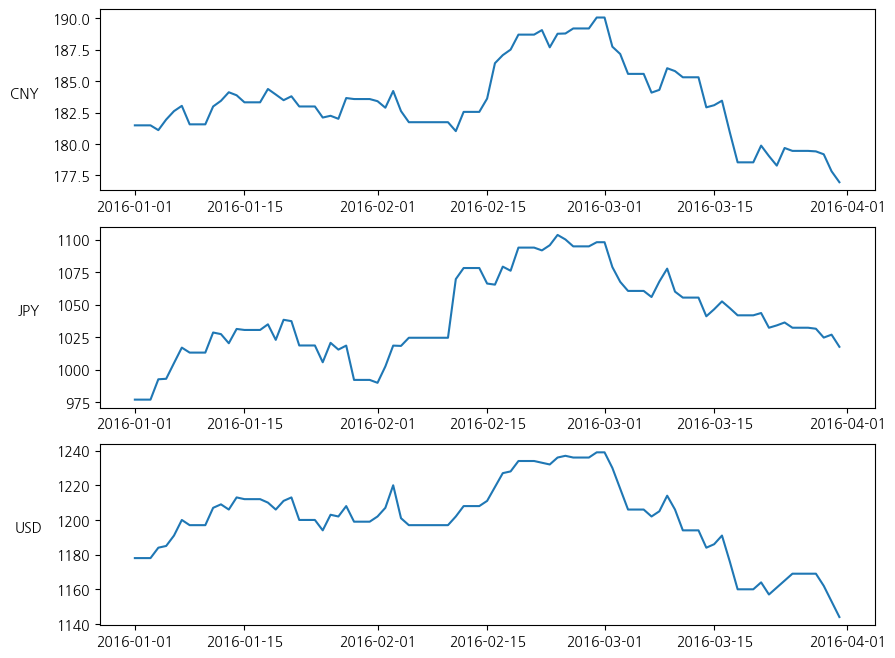

In [97]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (10,8))

for (ax, idx, currency) in zip ([ax1,ax2,ax3], [311,312,313], ['CNY','JPY','USD']):
    ax.plot('APPL_DATE', 'STD_RATE', data = df_raw[df_raw['CURRENCY']== currency])
    ax.set_ylabel(currency, rotation = 0 , labelpad = 20)

In [98]:
df_CNY = df_raw[df_raw['CURRENCY'] == "CNY"].set_index("APPL_DATE")
df_CNY.drop(["CURRENCY", "USD_CONV_DATE"], axis = 1 , inplace = True)

df_JPY = df_raw[df_raw["CURRENCY"] == "JPY"].set_index('APPL_DATE')
df_JPY.drop(["CURRENCY", "USD_CONV_DATE"], axis = 1 , inplace = True)

df_USD = df_raw[df_raw["CURRENCY"] == "USD"].set_index('APPL_DATE')
df_USD.drop(["CURRENCY", "USD_CONV_DATE"], axis = 1 , inplace = True)
df_CNY.head()

,STD_RATE
APPL_DATE,
2016-01-01,181.48
2016-01-02,181.48
2016-01-03,181.48
2016-01-04,181.10
2016-01-05,181.94


In [93]:
# 안해도 됨 
# train_size = 0.9
# len_idx = len(df_CNY.index)
# mask = (np.arange(len_idx) / len_idx) < train_size
# mask

In [94]:
# 안해도 됨 
# df_CNY_train = df_CNY[mask]
# df_CNY_test = df_CNY[~mask]
# print("shape of train data:{}".format(df_CNY_train.shape))
# print("shape of test data:{}".format(df_CNY_test.shape))

In [99]:
# 
df_CNY_train = df_CNY[df_CNY.index <= "2016-03-22"]
df_CNY_test = df_CNY[df_CNY.index > "2016-03-22"]
df_CNY_test.head()

,STD_RATE
APPL_DATE,
2016-03-23,178.28
2016-03-24,179.68
2016-03-25,179.45
2016-03-26,179.45
2016-03-27,179.45


<Axes: xlabel='APPL_DATE'>

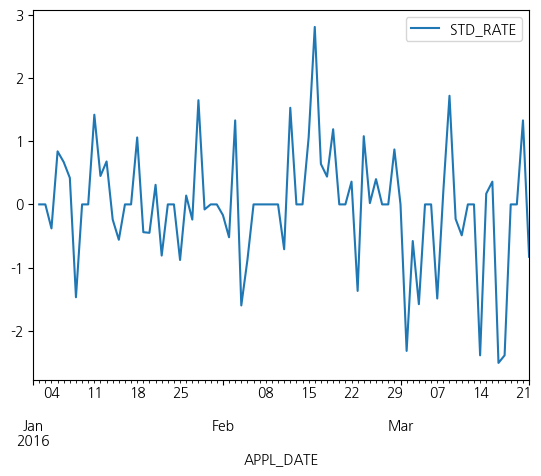

In [100]:
df_CNY_diff1 = df_CNY_train - df_CNY_train.shift(1)
df_CNY_diff1.plot()

<Axes: xlabel='APPL_DATE'>

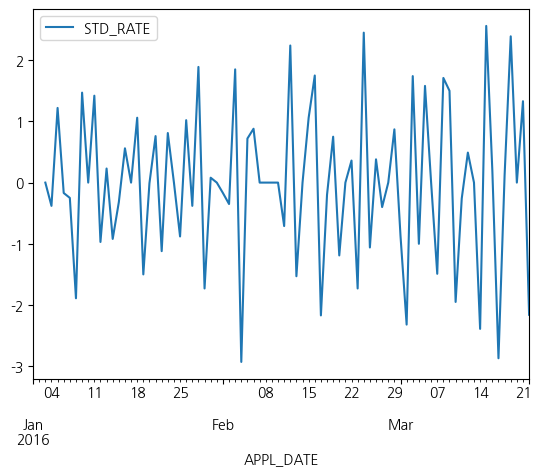

In [114]:
df_CNY_diff2 = df_CNY_train - 2 * (df_CNY_train.shift(1)) + (df_CNY_train.shift(2)) 
df_CNY_diff2.plot()

/home/piai/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


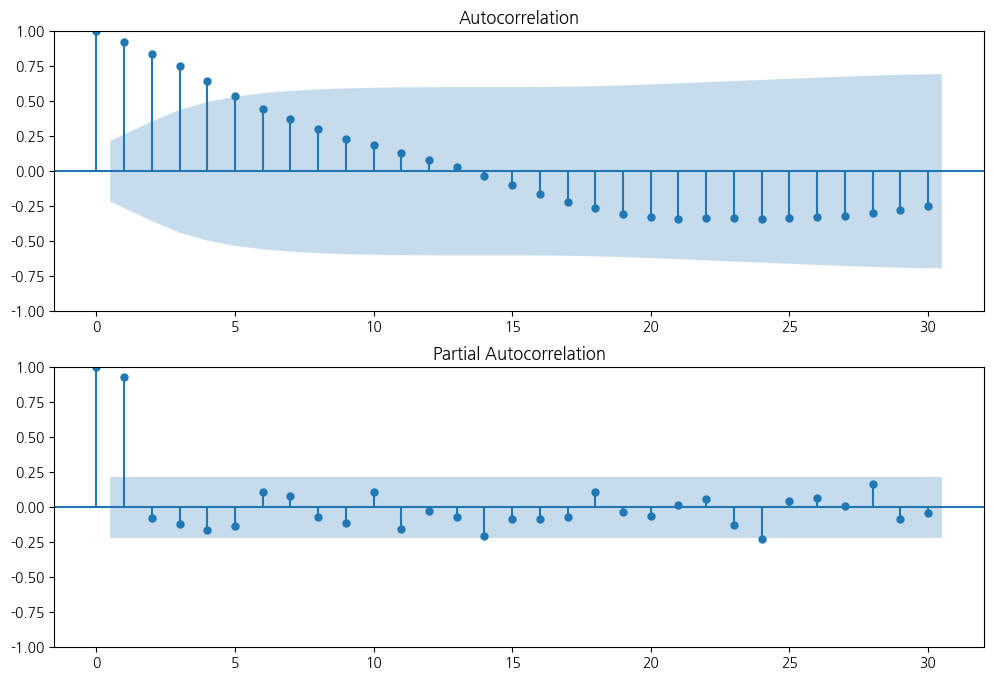

In [105]:
###  lag
lag_size = 30
fig = plt.figure(figsize = (12,8))

ax1 = fig.add_subplot(211)
fig = plot_acf(df_CNY_train["STD_RATE"], lags = lag_size, ax = ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(df_CNY_train["STD_RATE"], lags = lag_size, ax = ax2)

In [109]:
ts_model_cny = ARIMA(df_CNY_train, order = (1,2,0))

ts_result_cny = ts_model_cny.fit()
print(ts_result_cny.summary())

                               SARIMAX Results                                
Dep. Variable:               STD_RATE   No. Observations:                   82
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -123.513
Date:                Wed, 17 May 2023   AIC                            251.025
Time:                        16:30:19   BIC                            255.790
Sample:                    01-01-2016   HQIC                           252.936
                         - 03-22-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4389      0.106     -4.146      0.000      -0.646      -0.231
sigma2         1.2805      0.213      6.014      0.000       0.863       1.698
Ljung-Box (L1) (Q):                   2.62   Jarque-

/home/piai/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/piai/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/piai/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


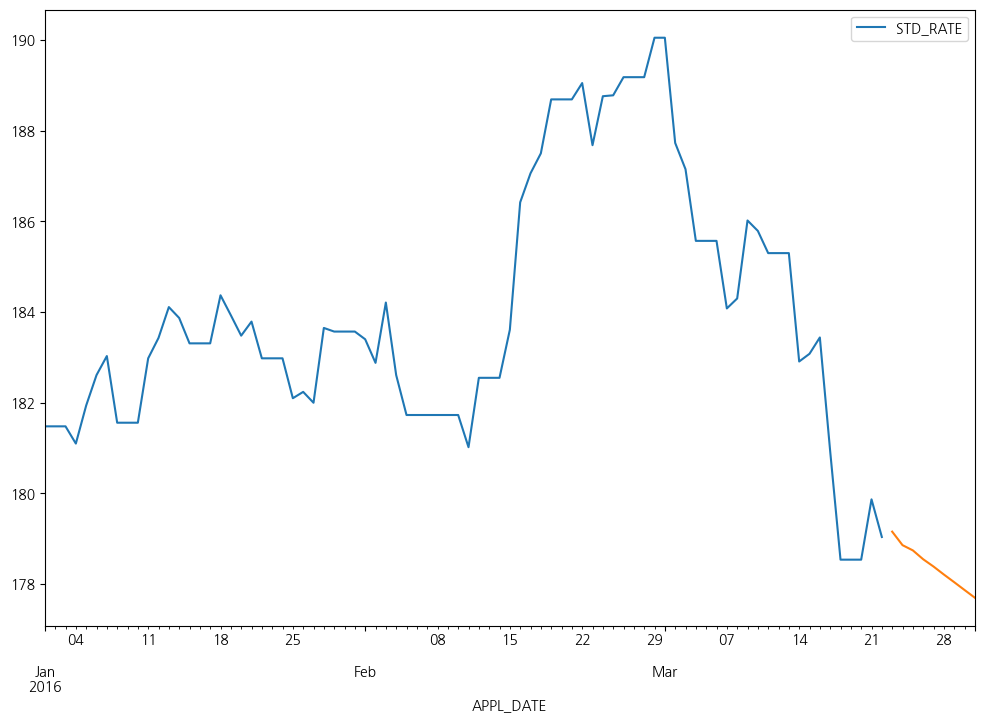

In [110]:
start_time = df_CNY_test.index.min()
end_time = df_CNY_test.index.max()
fig, ax = plt.subplots(figsize = (12,8))

ax = df_CNY_train.plot(ax=ax)
fig = ts_result_cny.predict(start=start_time, end=end_time, ax=ax, plot_insample = False).plot()

In [111]:
start_time = pd.to_datetime("2016-01-03")
y_pred = ts_result_cny.predict(start=start_time, end = end_time , typ = 'levels')
df_merge = df_CNY
df_merge["예측값"] = y_pred
df_merge.head()

,STD_RATE,예측값
APPL_DATE,,
2016-01-01,181.48,NaN
2016-01-02,181.48,NaN
2016-01-03,181.48,181.480126
2016-01-04,181.10,181.480000
2016-01-05,181.94,180.886777


<Axes: xlabel='APPL_DATE'>

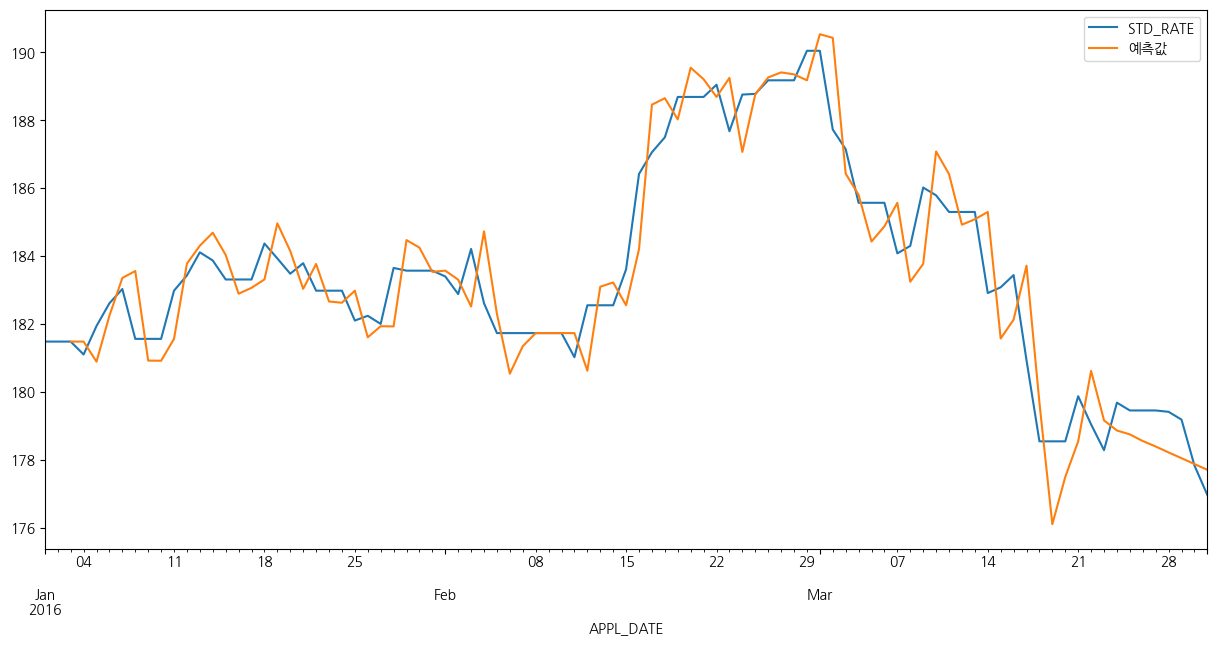

In [112]:
df_merge.plot( y=["STD_RATE", "예측값"], figsize = (15,7))

In [117]:
ts_model = auto_arima(df_CNY_train, max_p = 3, max_q = 3, d = 2,
                     trace=True, error_action = 'ignore')

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=228.840, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=265.705, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=251.025, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=223.626, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=225.299, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=225.249, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=226.997, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.455 seconds


In [118]:
ts_model_cny = ARIMA(df_CNY_train, order = (1,2,0))
ts_result_cny = ts_model_cny.fit()
print(ts_result_cny.summary())

                               SARIMAX Results                                
Dep. Variable:               STD_RATE   No. Observations:                   82
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -123.513
Date:                Wed, 17 May 2023   AIC                            251.025
Time:                        16:55:05   BIC                            255.790
Sample:                    01-01-2016   HQIC                           252.936
                         - 03-22-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4389      0.106     -4.146      0.000      -0.646      -0.231
sigma2         1.2805      0.213      6.014      0.000       0.863       1.698
Ljung-Box (L1) (Q):                   2.62   Jarque-

/home/piai/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/piai/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/piai/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


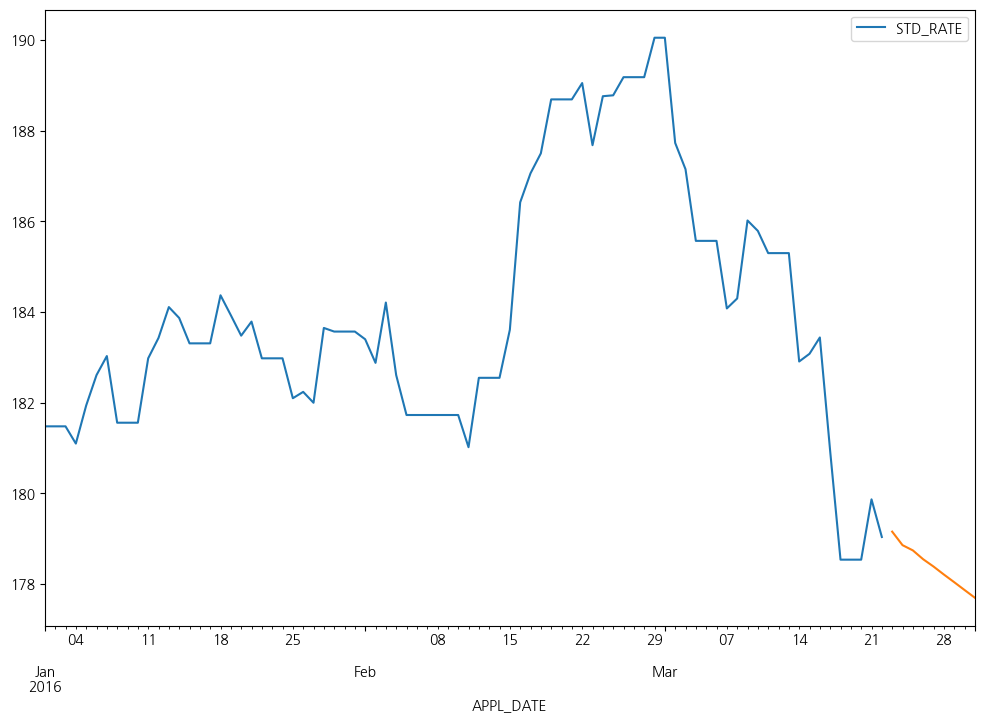

In [119]:
start_time = df_CNY_test.index.min()
end_time = df_CNY_test.index.max()
fig, ax = plt.subplots(figsize = (12,8))

ax = df_CNY_train.plot(ax=ax)
fig = ts_result_cny.predict(start=start_time, end=end_time, ax=ax, plot_insample = False).plot()

In [120]:
start_time = pd.to_datetime("2016-01-03")
y_pred = ts_result_cny.predict(start=start_time, end = end_time , typ = 'levels')
df_merge = df_CNY
df_merge["예측값"] = y_pred
df_merge.head()

,STD_RATE,예측값
APPL_DATE,,
2016-01-01,181.48,NaN
2016-01-02,181.48,NaN
2016-01-03,181.48,181.480126
2016-01-04,181.10,181.480000
2016-01-05,181.94,180.886777


<Axes: xlabel='APPL_DATE'>

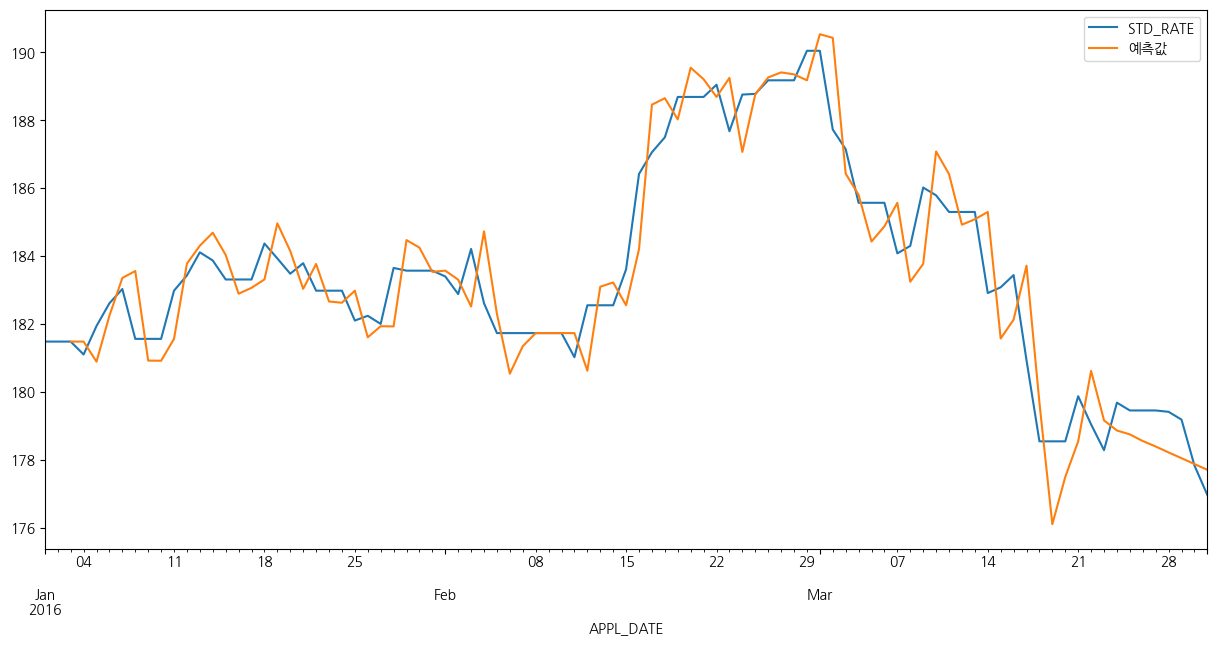

In [121]:
df_merge.plot( y=["STD_RATE", "예측값"], figsize = (15,7))

## 시계열 분석 실습

In [122]:
df_USD

,STD_RATE
APPL_DATE,
2016-01-01,1178.0
2016-01-02,1178.0
2016-01-03,1178.0
2016-01-04,1184.0
2016-01-05,1185.0
...,...
2016-03-27,1169.0
2016-03-28,1169.0
2016-03-29,1162.0


In [123]:
df_USD_train = df_USD[df_USD.index <= "2016-03-22"]
df_USD_test = df_USD[df_USD.index > "2016-03-22"]
df_USD_test.head()

,STD_RATE
APPL_DATE,
2016-03-23,1161.0
2016-03-24,1165.0
2016-03-25,1169.0
2016-03-26,1169.0
2016-03-27,1169.0


<Axes: xlabel='APPL_DATE'>

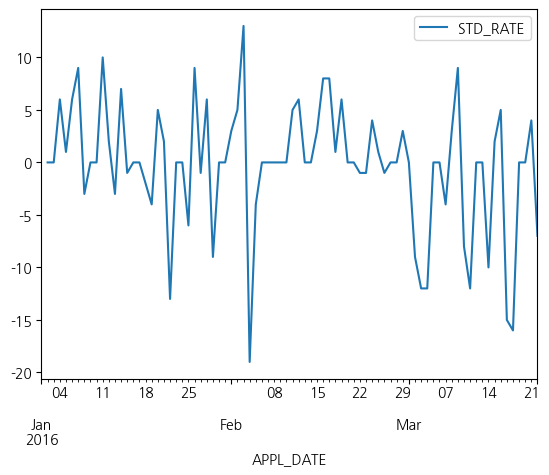

In [124]:
df_USD_diff1 = df_USD_train - df_USD_train.shift(1)
df_USD_diff1.plot()

<Axes: xlabel='APPL_DATE'>

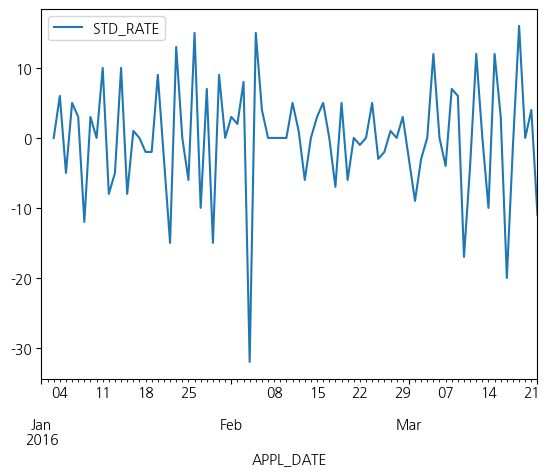

In [125]:
df_USD_diff2 = df_USD_train - 2 * (df_USD_train.shift(1)) + (df_USD_train.shift(2)) 
df_USD_diff2.plot()

/home/piai/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


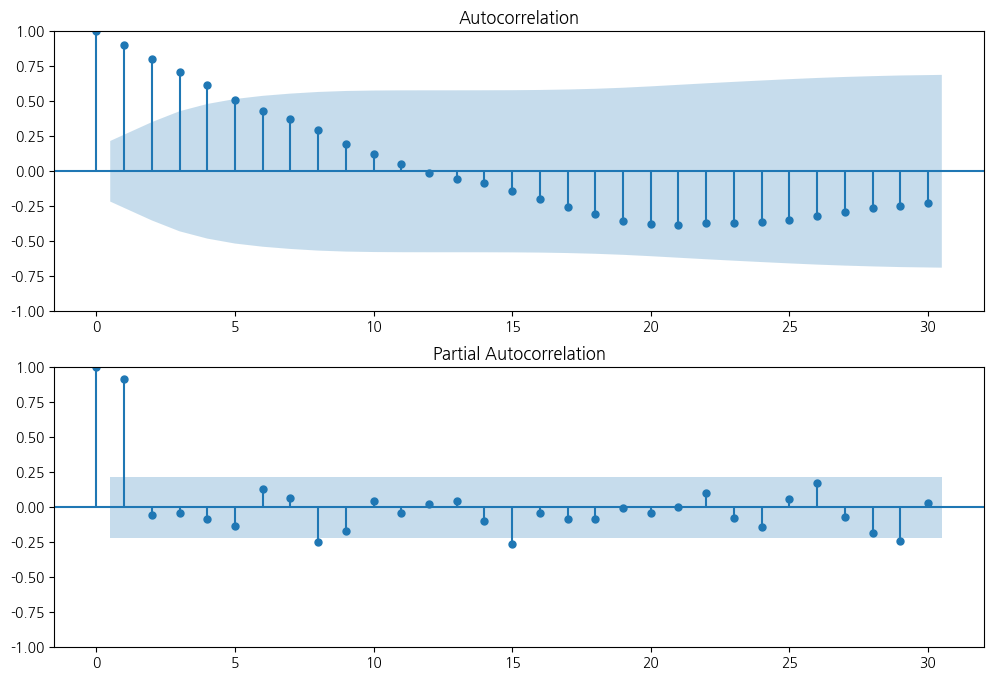

In [126]:
###  lag
lag_size = 30
fig = plt.figure(figsize = (12,8))

ax1 = fig.add_subplot(211)
fig = plot_acf(df_USD_train["STD_RATE"], lags = lag_size, ax = ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(df_USD_train["STD_RATE"], lags = lag_size, ax = ax2)

In [129]:
ts_model_USD = ARIMA(df_USD_train, order = (1,2,0))

ts_result_USD = ts_model_USD.fit()
print(ts_result_USD.summary())

                               SARIMAX Results                                
Dep. Variable:               STD_RATE   No. Observations:                   82
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -274.804
Date:                Wed, 17 May 2023   AIC                            553.608
Time:                        17:02:52   BIC                            558.372
Sample:                    01-01-2016   HQIC                           555.518
                         - 03-22-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3764      0.124     -3.047      0.002      -0.618      -0.134
sigma2        56.2767      7.107      7.919      0.000      42.348      70.206
Ljung-Box (L1) (Q):                   2.21   Jarque-

/home/piai/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/piai/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/piai/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


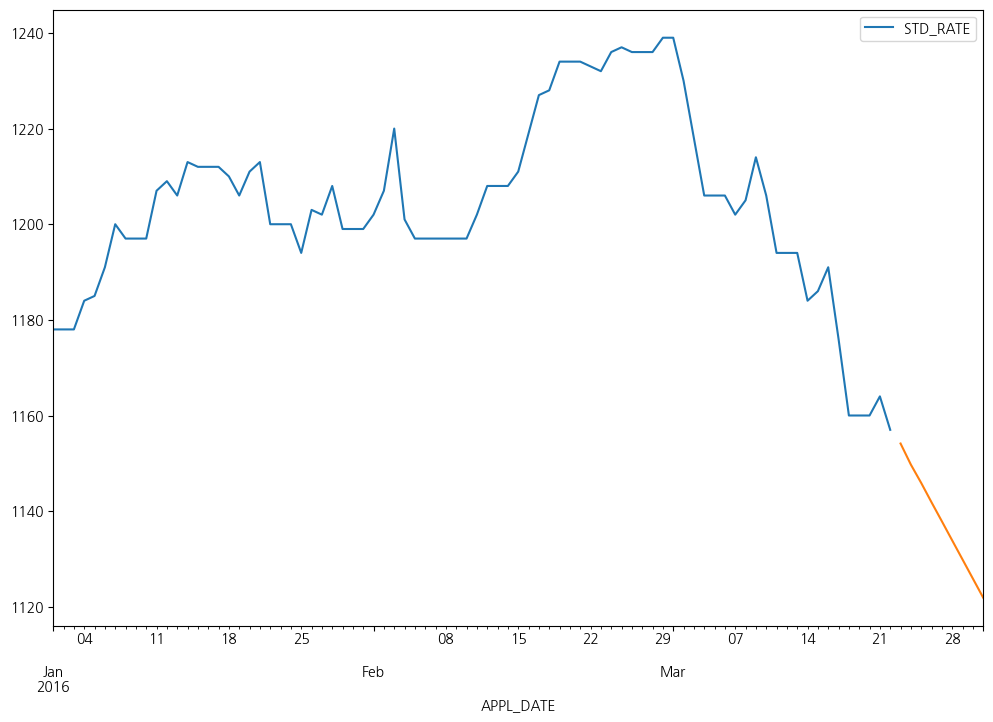

In [130]:
start_time = df_USD_test.index.min()
end_time = df_USD_test.index.max()
fig, ax = plt.subplots(figsize = (12,8))

ax = df_USD_train.plot(ax=ax)
fig = ts_result_USD.predict(start=start_time, end=end_time, ax=ax, plot_insample = False).plot()

In [131]:
start_time = pd.to_datetime("2016-01-03")
y_pred = ts_result_USD.predict(start=start_time, end = end_time , typ = 'levels')
df_merge = df_USD
df_merge["예측값"] = y_pred
df_merge.head()

,STD_RATE,예측값
APPL_DATE,,
2016-01-01,1178.0,NaN
2016-01-02,1178.0,NaN
2016-01-03,1178.0,1178.029066
2016-01-04,1184.0,1178.000000
2016-01-05,1185.0,1187.741796


<Axes: xlabel='APPL_DATE'>

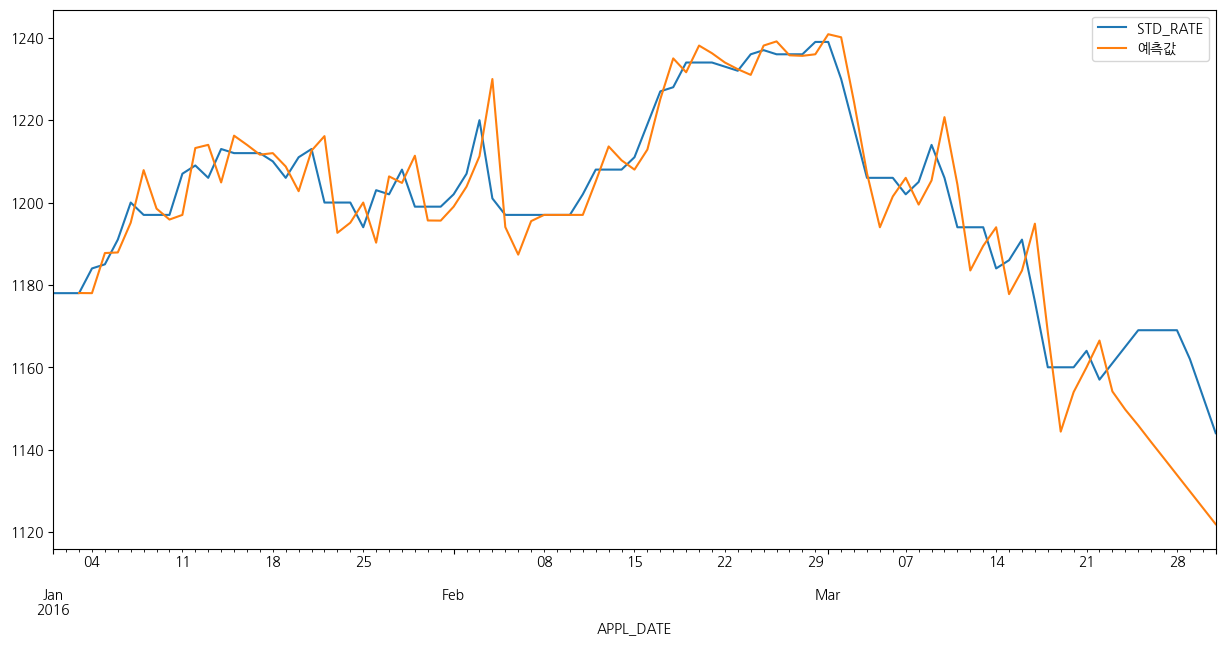

In [132]:
df_merge.plot( y=["STD_RATE", "예측값"], figsize = (15,7))

In [133]:
ts_model = auto_arima(df_USD_train, max_p = 3, max_q = 3, d = 2,
                     trace=True, error_action = 'ignore')

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=524.467, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=563.701, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=553.608, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=521.789, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=523.560, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=523.412, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=524.524, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.390 seconds


In [134]:
ts_model_USD = ARIMA(df_USD_train, order = (1,2,0))
ts_result_USD = ts_model_USD.fit()
print(ts_result_USD.summary())

                               SARIMAX Results                                
Dep. Variable:               STD_RATE   No. Observations:                   82
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -274.804
Date:                Wed, 17 May 2023   AIC                            553.608
Time:                        17:05:18   BIC                            558.372
Sample:                    01-01-2016   HQIC                           555.518
                         - 03-22-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3764      0.124     -3.047      0.002      -0.618      -0.134
sigma2        56.2767      7.107      7.919      0.000      42.348      70.206
Ljung-Box (L1) (Q):                   2.21   Jarque-

/home/piai/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/piai/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/piai/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


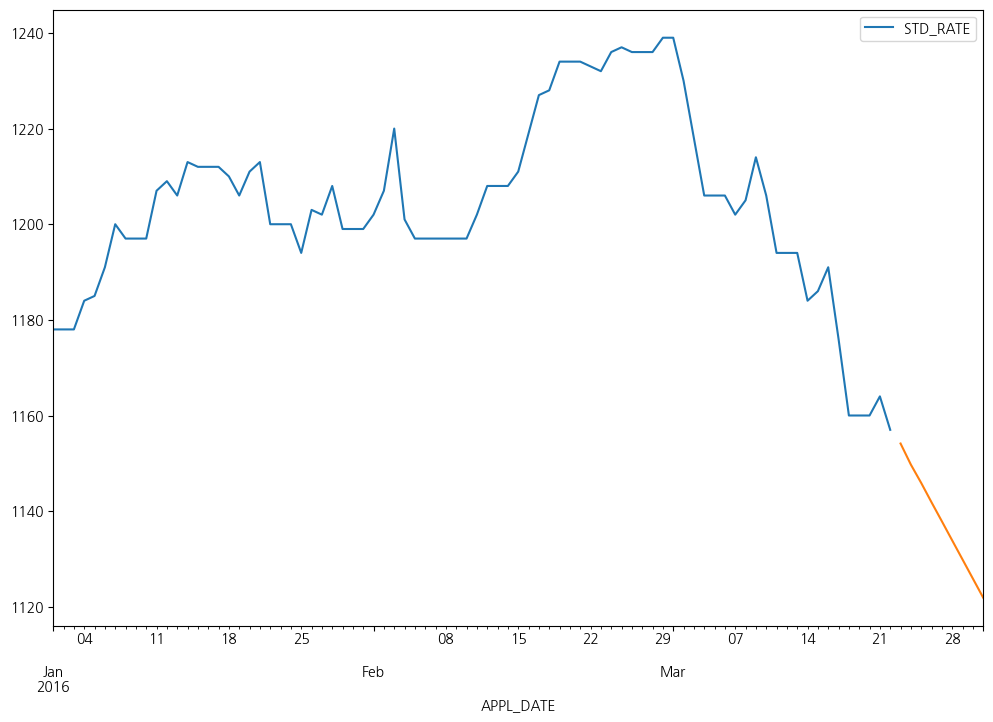

In [135]:
start_time = df_USD_test.index.min()
end_time = df_USD_test.index.max()
fig, ax = plt.subplots(figsize = (12,8))

ax = df_USD_train.plot(ax=ax)
fig = ts_result_USD.predict(start=start_time, end=end_time, ax=ax, plot_insample = False).plot()

In [136]:
start_time = pd.to_datetime("2016-01-03")
y_pred = ts_result_USD.predict(start=start_time, end = end_time , typ = 'levels')
df_merge = df_USD
df_merge["예측값"] = y_pred
df_merge.head()

,STD_RATE,예측값
APPL_DATE,,
2016-01-01,1178.0,NaN
2016-01-02,1178.0,NaN
2016-01-03,1178.0,1178.029066
2016-01-04,1184.0,1178.000000
2016-01-05,1185.0,1187.741796


<Axes: xlabel='APPL_DATE'>

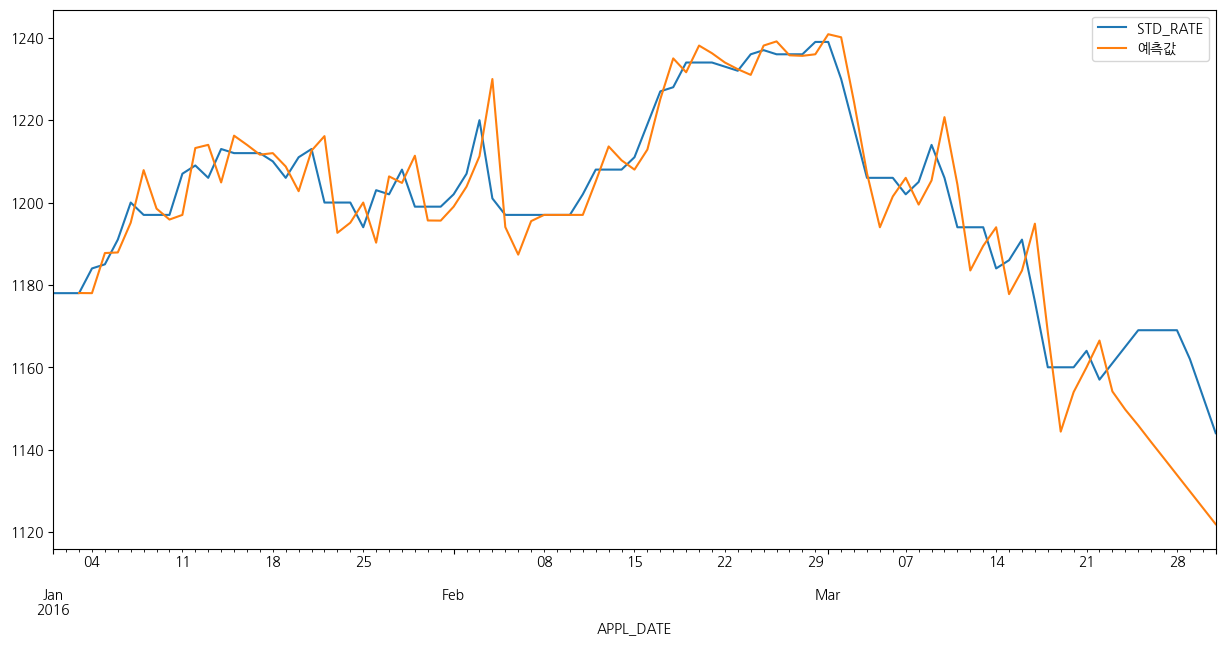

In [137]:
df_merge.plot( y=["STD_RATE", "예측값"], figsize = (15,7))